# Use case: CMIP6 Temperature Timeseries extraction

Earth Data Hub offers an innovative and super-efficient way to access data.

Here we present how to best access the service in the simplest use case.

## Setup the environment

**If you haven't done it already, follow the [Getting started notebook](./00-getting-started.ipynb) to setup your environment and DestinE credentials.**

## Download CMIP6 data for the grid point nearest to Rome
Our use case is to compare and visualise near-surface air temperature simulated by six different CMIP6 models.
We will examine results across various Shared Socio-economic Pathway (SSP) scenarios.

The best practices for retrieving data from the Earth Data Hub (EDH) include the following steps:
1. Open the datasets using the code snippets found on the [CMIP6 collection](https://earthdatahub.destine.eu/collections/cmip6) page.
2. Select the variable of interest.
3. Subset the data for the specific grid point.
4. Combine the data from all models into a single object.
5. Download and persist the data in memory (using `.persist()` or `.compute()`).
6. Save the processed data or perform final analysis.

### Silence noisy warnings
We'll hide some technical Zarr warnings just to keep the output clean.

In [1]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="Numcodecs codecs are not in the Zarr version 3 specification*",
    category=UserWarning,
)

### Open all datasets
The following cells assume you have configured your EDH Personal Access Token in your .netrc file.

In [2]:
import xarray as xr

urls = [
    "https://data.earthdatahub.destine.eu/cmip6/CMCC-CM2-SR5-historical-r1i1p1f1-day-gn-v0.zarr",
    "https://data.earthdatahub.destine.eu/cmip6/CMCC-CM2-SR5-ScenarioMIP-r1i1p1f1-day-gn-v0.zarr",
    "https://data.earthdatahub.destine.eu/cmip6/DKRZ-MPI-ESM1-2-HR-historical-r1i1p1f1-day-gn-v0.zarr",
    "https://data.earthdatahub.destine.eu/cmip6/DKRZ-MPI-ESM1-2-HR-ScenarioMIP-r1i1p1f1-day-gn-v0.zarr",
    "https://data.earthdatahub.destine.eu/cmip6/EC-Earth3-CC-historical-r1i1p1f1-day-gr-v0.zarr",
    "https://data.earthdatahub.destine.eu/cmip6/EC-Earth3-CC-ScenarioMIP-r1i1p1f1-day-gr-v0.zarr",
    "https://data.earthdatahub.destine.eu/cmip6/IPSL-CM6A-LR-historical-r1i1p1f1-day-gr-v0.zarr",
    "https://data.earthdatahub.destine.eu/cmip6/IPSL-CM6A-LR-ScenarioMIP-r1i1p1f1-day-gr-v0.zarr",
    "https://data.earthdatahub.destine.eu/cmip6/NCAR-CESM2-historical-r1i1p1f1-day-gn-v0.zarr",
    "https://data.earthdatahub.destine.eu/cmip6/NCAR-CESM2-ScenarioMIP-r10i1p1f1-day-gn-v0.zarr",
    "https://data.earthdatahub.destine.eu/cmip6/NCC-NorESM2-MM-historical-r1i1p1f1-day-gn-v0.zarr",
    "https://data.earthdatahub.destine.eu/cmip6/NCC-NorESM2-MM-ScenarioMIP-r1i1p1f1-day-gn-v0.zarr",
]

datasets = {}
for url in urls:
    print(f"Opening {url=}")
    datasets[url] = xr.open_dataset(
        url,
        storage_options={"client_kwargs": {"trust_env": True}},
        chunks={},
        engine="zarr",
    )

Opening url='https://data.earthdatahub.destine.eu/cmip6/CMCC-CM2-SR5-historical-r1i1p1f1-day-gn-v0.zarr'
Opening url='https://data.earthdatahub.destine.eu/cmip6/CMCC-CM2-SR5-ScenarioMIP-r1i1p1f1-day-gn-v0.zarr'
Opening url='https://data.earthdatahub.destine.eu/cmip6/DKRZ-MPI-ESM1-2-HR-historical-r1i1p1f1-day-gn-v0.zarr'
Opening url='https://data.earthdatahub.destine.eu/cmip6/DKRZ-MPI-ESM1-2-HR-ScenarioMIP-r1i1p1f1-day-gn-v0.zarr'
Opening url='https://data.earthdatahub.destine.eu/cmip6/EC-Earth3-CC-historical-r1i1p1f1-day-gr-v0.zarr'
Opening url='https://data.earthdatahub.destine.eu/cmip6/EC-Earth3-CC-ScenarioMIP-r1i1p1f1-day-gr-v0.zarr'
Opening url='https://data.earthdatahub.destine.eu/cmip6/IPSL-CM6A-LR-historical-r1i1p1f1-day-gr-v0.zarr'
Opening url='https://data.earthdatahub.destine.eu/cmip6/IPSL-CM6A-LR-ScenarioMIP-r1i1p1f1-day-gr-v0.zarr'
Opening url='https://data.earthdatahub.destine.eu/cmip6/NCAR-CESM2-historical-r1i1p1f1-day-gn-v0.zarr'
Opening url='https://data.earthdatahub.de

### Select and prepare the variable
In order to combine multiple models into a single Xarray object, we must first perform a few processing steps:
1. Select the variable of interest.
2. Subset the data for the location of interest.
3. Subset the data for the period of interest.
4. Compute annual means to evaluate yearly trends.
5. Expand the metadata by adding `model` and `experiment_id` as new dimensions.
6. Drop years overlapping between historical and scenario runs.

Note: These operations are lazy. The transformations are not applied to the data immediately; instead, they are recorded in a task graph. Data retrieval and actual computations are only executed when explicitly requested.

In [3]:
dataarrays = []
for url, ds in datasets.items():
    # 1. Select temperature
    da = ds["tas"].reset_coords(drop=True)
    # 2. Extract Rome
    da = da.sel(lat=41.8967, lon=12.4822, method="nearest", drop=True)
    # 3. Select time period
    da = da.sel(time=slice("1850", "2100"))
    # 4. Compute annual mean
    da = da.groupby("time.year").mean()
    # 5. Expand the metadata
    da = da.expand_dims(model=url.rsplit("/", 1)[-1].rsplit("-", 5)[:1])
    if "experiment_id" not in da.dims:
        da = da.expand_dims(experiment_id=["historical"])
        # 6. Drop overlapping years
        da = da.sel(year=slice(None, 2014))
    dataarrays.append(da.chunk(year=-1))
ds = xr.combine_by_coords(dataarrays, combine_attrs="drop_conflicts", join="outer", coords="minimal")
ds["experiment_id"] = ds["experiment_id"].astype("U")  # Force unicode for plotting compatibility

In [4]:
display(ds)

<xarray.Dataset> Size: 51kB
Dimensions:        (experiment_id: 8, model: 6, year: 251)
Coordinates:
  * experiment_id  (experiment_id) <U10 320B 'historical' 'ssp119' ... 'ssp585'
  * model          (model) object 48B 'CMCC-CM2-SR5' ... 'NCC-NorESM2-MM'
  * year           (year) int64 2kB 1850 1851 1852 1853 ... 2097 2098 2099 2100
Data variables:
    tas            (experiment_id, model, year) float32 48kB dask.array<chunksize=(1, 1, 165), meta=np.ndarray>

### Download the data into memory

Finally, we are ready to download the specific data we need into memory.

The best practice is to call the `.compute()` method, which triggers the actual data retrieval and loads the result into a NumPy array.

**This operation is the slow one. It takes up to 2 minutes on a 8 Mbps connection.**

It depends on the download speed of your internet connection and on the load on the Earth Data Hub. The closer you are to the data the faster it is, and this is one of the reason the EDH is best suited to be used from within the DestinE platform.

In [5]:
tas_kelvin = ds["tas"].compute()

### Perform any computation

Now that the data is loaded, we can perform any final operations.
In this example, we convert the temperature from Kelvin to Celsius and plot the results to visualise the trends across different models and scenarios.

In [6]:
with xr.set_options(keep_attrs=True):
    tas_celsius = tas_kelvin - 273.15
tas_celsius.attrs["units"] = "°C"

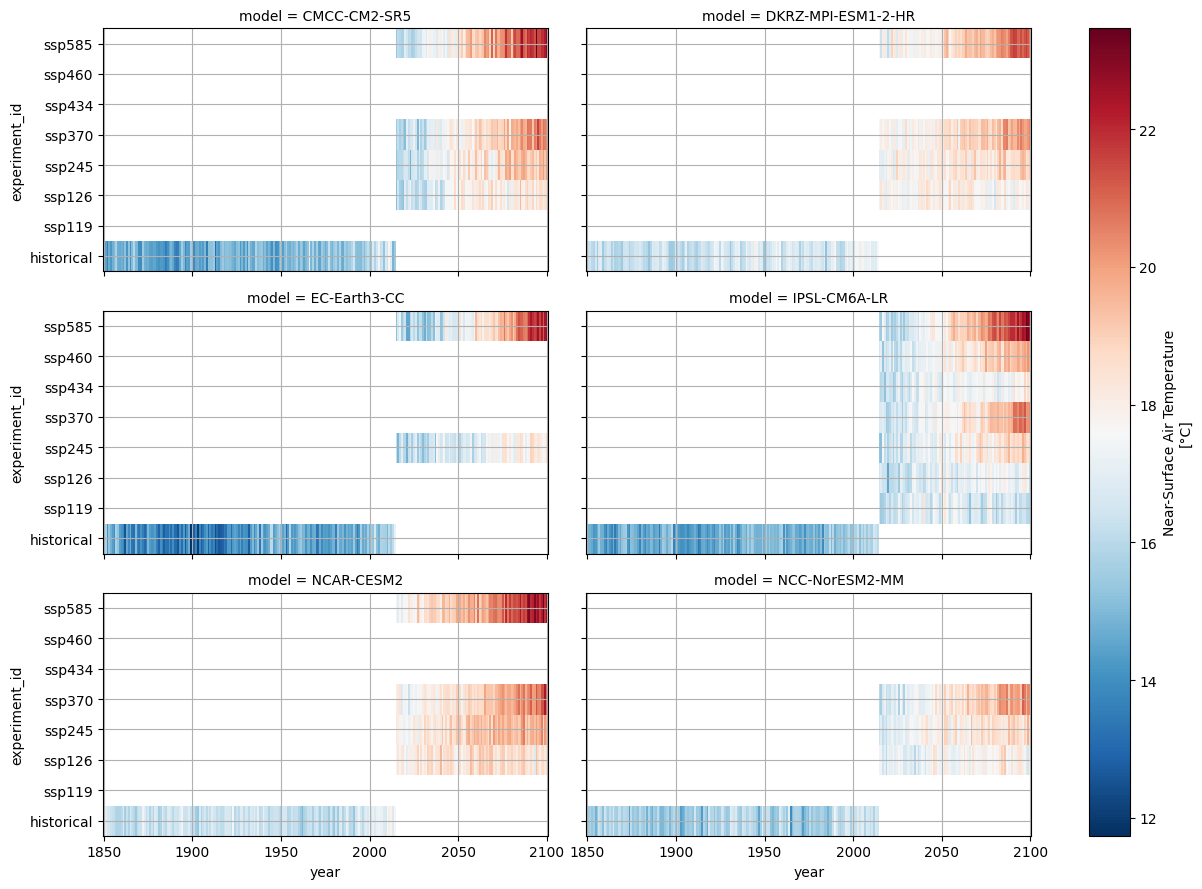

In [7]:
facet = tas_celsius.plot.imshow(col="model", col_wrap=2, cmap="RdBu_r", aspect=2)
for ax in facet.axs.flatten():
    ax.grid()
display(facet)